In [1]:
import pickle

In [2]:
result_nn = open('Results/5_Results_NN.pkl', 'rb')
result_nn1 = pickle.load(result_nn)
print(result_nn1)

{'NoFG_NoPrior_': {0: 0.5508981943130493, 1: 0.5269461274147034, 2: 0.5508981943130493, 3: 0.5508981943130493, 4: 0.5508981943130493}, 'NoFG_Prior_': {0: 0.5508981943130493, 1: 0.5508981943130493, 2: 0.5508981943130493, 3: 0.5508981943130493, 4: 0.5628742575645447}, 'FG_Prior_': {0: 0.5508981943130493, 1: 0.5329341292381287, 2: 0.5508981943130493, 3: 0.5508981943130493, 4: 0.5508981943130493}}


In [4]:
from _5_processing_functions import *
from tensorflow import keras
import keras_tuner as kerastuner
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    BatchNormalization
)
import numpy as np
from sklearn import model_selection
import tensorflow as tf


def build_model(hp):
    METRICS = ['accuracy', tf.keras.metrics.AUC(name='auc', num_thresholds=200)]

    model = keras.Sequential()

    for i in range(hp.Choice('num_layers', [1, 2, 3, 4, 5, 6, 10])):
        model.add(Dense(units=hp.Choice('layer_' + str(i) + '_width', [4, 8, 16, 32, 64, 128, 256]),
                        kernel_initializer=hp.Choice('kernel_' + str(i), ['glorot_uniform', 'glorot_normal', 'TruncatedNormal', 'Zeros']),
                        activation=hp.Choice('activation_' + str(i), ['relu', 'tanh']),
                        kernel_regularizer=tf.keras.regularizers.l1(hp.Choice('learning_rate' + str(i), [1.0,0.1, 0.01, 0.001]))))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Choice('dropout_' + str(i), [0.0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9])))

    # Add different optimizers
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [10.0, 1.0, 0.1, 0.01, 0.001, 0.0001])),
                  loss='binary_crossentropy',
                  metrics=METRICS)
    return model


class CVTuner(kerastuner.engine.tuner.Tuner):
    def run_trial(self, trial, train, test, executions=3, *args, **kwargs):
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0, patience=25, verbose=0,
            mode='min', baseline=None, restore_best_weights=True
        )

        kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', [8, 16, 32, 64, 128, 256])
        print(kwargs)
        exec_store = []
        exec_store_loss = []
        for exe in range(executions):
            cv = model_selection.KFold(5, shuffle=True)
            val_acc = []
            val_loss = []
            for train_indices, test_indices in cv.split(train):
                x_train, x_val = train[train_indices], train[test_indices]
                x_train, y_train, x_val, y_val, _1, _2 = processing_cv(x_train, x_val, test, seq=False,
                                                                       fg=kwargs['f_graph'])

                model = self.hypermodel.build(trial.hyperparameters)
                model.fit(x_train, y_train,
                          batch_size=kwargs['batch_size'],
                          epochs=kwargs['epochs'],
                          validation_data=(x_val, y_val),
                          callbacks=[early_stop])

                val_acc.append(model.evaluate(x_val, y_val)[1])
                val_loss.append(model.evaluate(x_val, y_val)[0])
            # Mean or max??
            exec_store.append(np.mean(val_acc))
            exec_store_loss.append(np.mean(val_loss))

        self.oracle.update_trial(trial.trial_id, {'val_accuracy': np.mean(exec_store),
                                                  'val_loss': np.mean(exec_store_loss)})
        self.save_model(trial.trial_id, model)


In [24]:
tuner = CVTuner(
        hypermodel=build_model,
        oracle=kerastuner.oracles.BayesianOptimization(
            objective=kerastuner.Objective("val_accuracy", direction="max"),
            max_trials=300),
        directory='Tuning/NoFG_Prior_',
        project_name='NN_tuning')

INFO:tensorflow:Reloading Oracle from existing project Tuning/NoFG_Prior_/NN_tuning/oracle.json
INFO:tensorflow:Reloading Tuner from Tuning/NoFG_Prior_/NN_tuning/tuner0.json


In [56]:
x = tuner.get_best_hyperparameters(10)[2]
df = pd.read_csv('Data/Cleaned/NoFG_NoPrior_Present.csv')
train, test = train_test_split(df.sample(frac = 1))
train, val = train_validation_split(train)
x_train, y_train, x_val, y_val, x_test, y_test = processing_cv(train, val, test, fg=(False, 0))

In [60]:
early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0, patience=25, verbose=0,
            mode='min', baseline=None, restore_best_weights=True
        )

hypermodel = tuner.hypermodel.build(x)
        # Retrain the model
hist = hypermodel.fit(x_train, y_train, epochs=250, validation_data=(x_val, y_val), callbacks =[early_stop], verbose = 0)

t = hypermodel.evaluate(x_test, y_test)[1]

print(t)

167/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [61]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, hypermodel.predict(x_test) > 0.5)
print(cm)

cm = confusion_matrix(y_test, hypermodel.predict(x_test) > 0.5, normalize = 'true')
print(cm)
cm = np.round(cm, decimals=2)

[[15 56]
 [28 68]]
[[0.21126761 0.78873239]
 [0.29166667 0.70833333]]


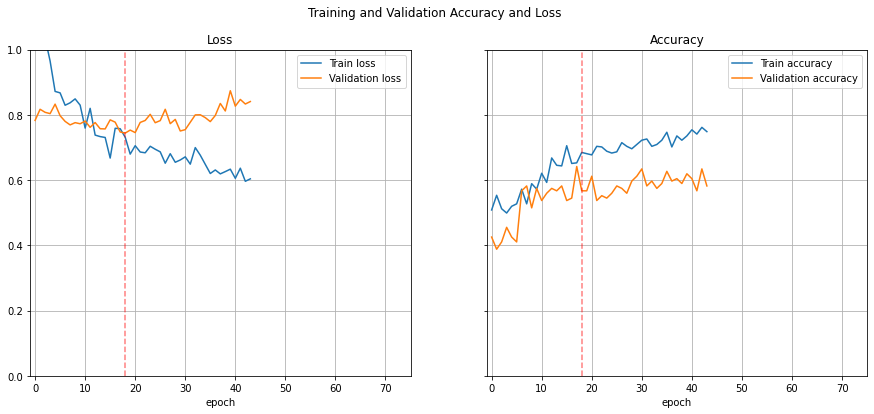

In [62]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, sharex=True, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(15)

best_e = early_stop.stopped_epoch - 25

history = hist
fig.suptitle('Training and Validation Accuracy and Loss')
axs[0].set_title('Loss')
axs[0].plot(history.history['loss'], label='Train loss')
axs[0].plot(history.history['val_loss'], label='Validation loss')
axs[0].legend()
axs[0].grid(True)
axs[0].set_xlim([-1, 75 ])
axs[0].set_ylim([0,1.0])
axs[0].set_xlabel('epoch')
axs[0].axvline(x=best_e, color='r', linestyle='--', alpha = 0.5)
# axs[0, 0].axvline(x=simple_e, color='r', linestyle='--', alpha = 0.5)


axs[1].set_title('Accuracy')
axs[1].plot(history.history['accuracy'], label='Train accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation accuracy')
axs[1].legend()
axs[1].grid(True)
axs[1].set_xlim([-1,75])
axs[1].set_ylim([0,1.0])
axs[1].set_xlabel('epoch')
axs[1].axvline(x=best_e, color='r', linestyle='--', alpha = 0.5)
# axs[0, 1].axvline(x=simple_e, color='r', linestyle='--', alpha = 0.5)

plt.savefig('PlotsForDiss/NoPrior_NoFG_NN.png')

hypermodel.save('Final_Models/NoFG_NoPrior_NN.h5')